In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 26 11:36:35 2021

@author: madse
"""

import netCDF4 as nc
import glob
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import pytz


def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians([lat1, lon1])
    lat2_rad, lon2_rad = np.radians([lat2, lon2])
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    # Haversine formula
    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance


def find_nearest_grid_point_and_distance(nc_fid, lat_target, lon_target):
    lat_idx = np.unravel_index(
        np.abs(nc_fid.variables["XLAT"][:] - lat_target).argmin(),
        nc_fid.variables["XLAT"][:].shape,
    )
    lon_idx = np.unravel_index(
        np.abs(nc_fid.variables["XLONG"][:] - lon_target).argmin(),
        nc_fid.variables["XLONG"][:].shape,
    )
    lat_nearest = nc_fid.variables["XLAT"][lat_idx]
    lon_nearest = nc_fid.variables["XLONG"][lon_idx]
    dist_to_CAMS = haversine(lat_target, lon_target, lat_nearest, lon_nearest)
    return dist_to_CAMS


def get_int_var(nc_fid, lat_target, lon_target, WRF_var):
    interpolated_var_dX = griddata(
        (
            nc_fid.variables["XLAT"][:].flatten(),
            nc_fid.variables["XLONG"][:].flatten(),
        ),
        nc_fid.variables[WRF_var][:].flatten(),
        (lat_target, lon_target),
        method="linear",
    )
    return interpolated_var_dX


def proj_on_finer_grid(
    lats_coarse, lons_coarse, var_coarse, lats_fine, lons_fine, WRF_var_d3
):
    proj_var = griddata(
        (lats_coarse.flatten(), lons_coarse.flatten()),
        var_coarse.flatten(),
        (lats_fine, lons_fine),
        method="linear",
    ).reshape(WRF_var_d3.shape)
    return proj_var


def proj_CAMS_on_WRF_grid(
    lats_coarse, lons_coarse, var_coarse, lats_fine, lons_fine, WRF_var_d3
):
    # Corrected meshgrid order
    lons_coarse_2d, lats_coarse_2d = np.meshgrid(lons_coarse, lats_coarse)
    # Reverse the order of latitude coordinates
    lat_CAMS_2d_reversed = lats_coarse_2d[::-1]
    # Reverse the order of the variable values
    var_coarse_reversed = np.flipud(var_coarse)
    # Flatten the coordinates
    points_coarse = np.column_stack(
        (lat_CAMS_2d_reversed.flatten(), lons_coarse_2d.flatten())
    )
    points_fine = np.column_stack((lats_fine.flatten(), lons_fine.flatten()))
    # Perform interpolation
    proj_var = griddata(
        points_coarse, var_coarse_reversed.flatten(), points_fine, method="nearest"
    ).reshape(WRF_var_d3.shape)

    return proj_var


def extract_datetime_from_filename(filename):
    """
    Extract datetime from WRF filename assuming format 'wrfout_d0x_YYYY-MM-DD_HH:MM:SS'.
    """
    base_filename = os.path.basename(filename)
    date_str = base_filename.split('_')[-2] + '_' + base_filename.split('_')[-1]
    return datetime.strptime(date_str, '%Y-%m-%d_%H:%M:%S')



In [49]:


# set standard deviation of topography
STD_VAL = 50
VEGFRA_percentage = 10
# select range of T_refs
T_ref_values = range(290, 304, 1)
df_coeff = pd.DataFrame(index=T_ref_values)
# set True if you want plots
plotting_plots = True



In [50]:
# Input dates
start_date = "2012-07-01 00:00:00"
end_date = "2012-07-08 00:00:00"

# Convert input dates to datetime objects with UTC timezone
start_date_obj = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.UTC)
end_date_obj = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.UTC)

# File path
file_path = '/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_AT-Neu_FLUXNET2015_FULLSET_2002-2012_1-4/FLX_AT-Neu_FLUXNET2015_FULLSET_HH_2002-2012_1-4.csv'

# Read CSV and create a DataFrame
df_FLX_site = pd.read_csv(file_path, sep=',')

# Drop the second row (index 0 is the header, index 1 contains units)
df_FLX_site = df_FLX_site.drop(index=0)

# Parse 'TIMESTAMP_START' from the raw format
df_FLX_site['TIMESTAMP_START'] = pd.to_datetime(df_FLX_site['TIMESTAMP_START'], format="%Y%m%d%H%M", errors='coerce')

# Check for parsing errors
if df_FLX_site['TIMESTAMP_START'].isna().any():
    print("Some 'TIMESTAMP_START' values could not be parsed.")
    print(df_FLX_site[df_FLX_site['TIMESTAMP_START'].isna()])

# Convert to UTC timezone (assume 'Europe/Berlin' for initial localization)
df_FLX_site['TIMESTAMP_START'] = df_FLX_site['TIMESTAMP_START'].dt.tz_localize('Europe/Berlin', nonexistent='shift_forward', ambiguous='NaT')
df_FLX_site['TIMESTAMP_START'] = df_FLX_site['TIMESTAMP_START'].dt.tz_convert('UTC')

# Filter the DataFrame based on the date range
df_FLX_site = df_FLX_site[
    (df_FLX_site['TIMESTAMP_START'] >= start_date_obj) &
    (df_FLX_site['TIMESTAMP_START'] <= end_date_obj)
]

# Debugging: Check the filtered data
print("Filtered DataFrame shape:", df_FLX_site.shape)

if df_FLX_site.empty:
    print("No data in the specified date range.")

# Select relevant columns and clean
df_FLX_site = df_FLX_site[['TIMESTAMP_START', 'GPP_NT_VUT_USTAR50', 'RECO_NT_VUT_USTAR50', 'TA_F']].copy()
df_FLX_site = df_FLX_site.mask(df_FLX_site == -9999, np.nan)

# Ensure GPP_NT_VUT_USTAR50 is negative
df_FLX_site['GPP_NT_VUT_USTAR50'] = -df_FLX_site['GPP_NT_VUT_USTAR50']

# Display the filtered DataFrame
print("Filtered and cleaned DataFrame:\n", df_FLX_site.head())


Filtered DataFrame shape: (337, 234)
Filtered and cleaned DataFrame:
                  TIMESTAMP_START  GPP_NT_VUT_USTAR50  RECO_NT_VUT_USTAR50  \
184036 2012-07-01 00:00:00+00:00           -2.277260              13.1167   
184037 2012-07-01 00:30:00+00:00           -0.333095              12.6148   
184038 2012-07-01 01:00:00+00:00           -0.809497              12.7382   
184039 2012-07-01 01:30:00+00:00           -0.814993              12.7437   
184040 2012-07-01 02:00:00+00:00            0.955428              12.1912   

          TA_F  
184036  16.768  
184037  15.798  
184038  16.050  
184039  16.071  
184040  14.994  


In [51]:
# FAIR time series
FLX_sitegpp = df_FLX_site.set_index('TIMESTAMP_START')['GPP_NT_VUT_USTAR50']
FLX_sitereco = df_FLX_site.set_index('TIMESTAMP_START')['RECO_NT_VUT_USTAR50']
FLX_siteT2 = df_FLX_site.set_index('TIMESTAMP_START')['TA_F']

# Convert FAIR time to match WRF time steps if necessary
FLX_sitegpp = FLX_sitegpp[start_date:end_date]
FLX_sitereco = FLX_sitereco[start_date:end_date]
FLX_siteT2 = FLX_siteT2[start_date:end_date]



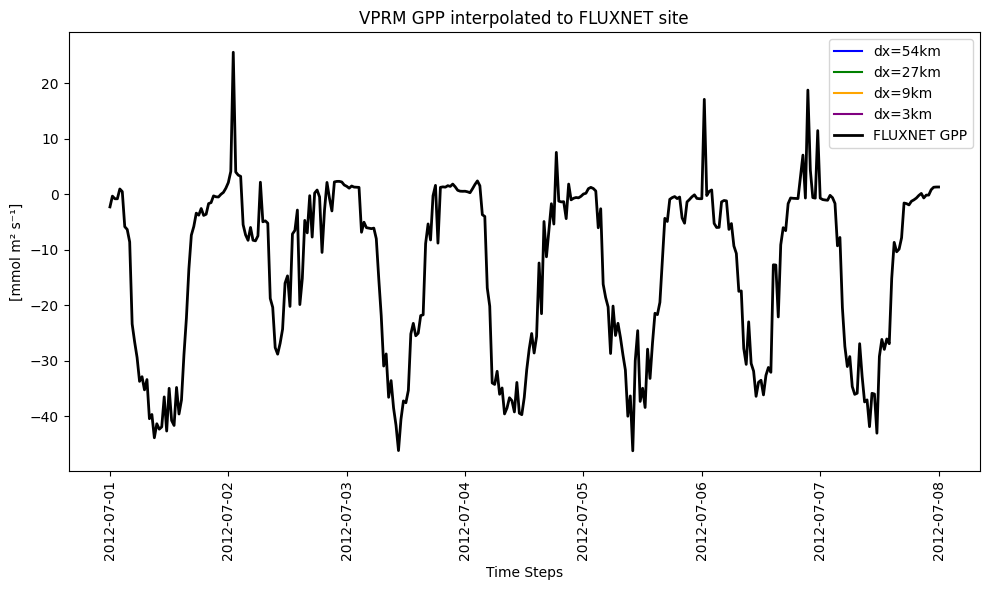

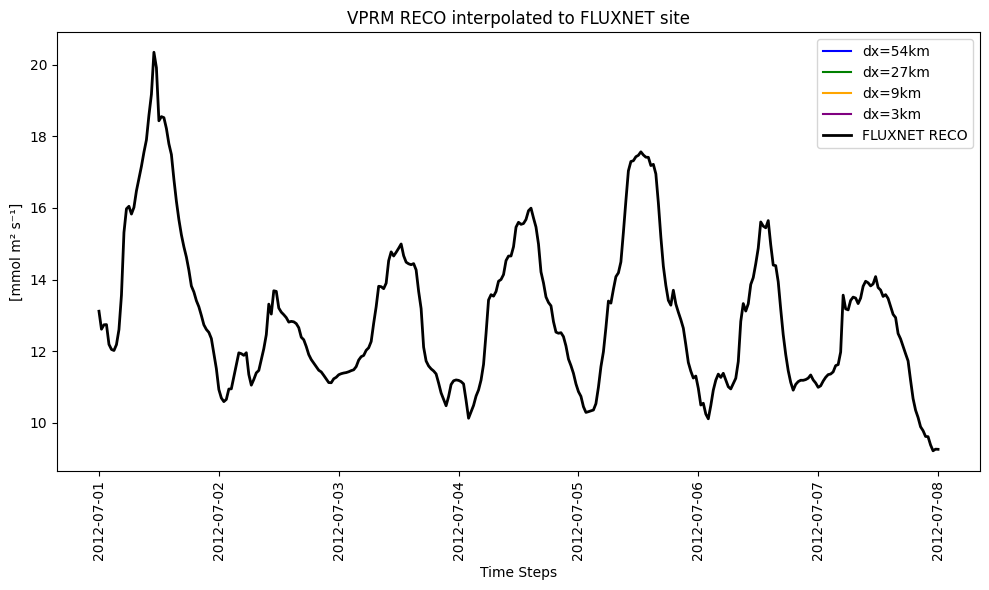

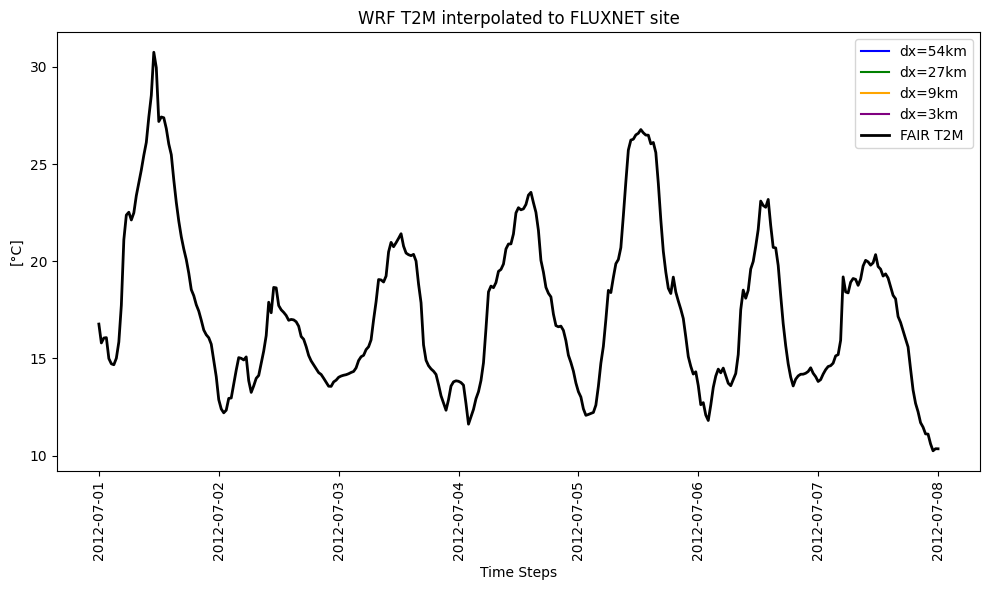

In [52]:
start_date = "2012-07-01 00:00:00"
end_date = "2012-07-08 00:00:00"
# WRF factors, variables, and units
factors = [1 / 3600, 1 / 3600, 1]  # conversion from mol /km²/s to  mumol/m²/s
WRF_vars = ["EBIO_GEE", "EBIO_RES", "T2"]
units = ["[mmol m² s⁻¹]", "[mmol m² s⁻¹]", "[°C]"]
name_vars = {"EBIO_GEE": "VPRM GPP", "EBIO_RES": "VPRM RECO", "T2": "WRF T2M"}

# Define paths and other variables
lat_target = 47.1167
lon_target = 11.3175
wrf_path1 = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_081552_ALPS_3km"
wrf_path2 = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_064407_ALPS_9km" 
wrf_path3 = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_091814_ALPS_27km" 
wrf_path4 = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241227_183215_ALPS_54km" 

start_date_obj = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

formatted_date = start_date_obj.strftime("%Y_%m_%d")

file_list_d4_1 = [f for f in sorted(glob.glob(os.path.join(wrf_path4, "wrfout_d01*"))) if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]
file_list_d3_1 = [f for f in sorted(glob.glob(os.path.join(wrf_path3, "wrfout_d01*"))) if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]
file_list_d2_1 = [f for f in sorted(glob.glob(os.path.join(wrf_path2, "wrfout_d01*"))) if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]
file_list_d1_1 = [f for f in sorted(glob.glob(os.path.join(wrf_path1, "wrfout_d01*"))) if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]


for WRF_var, factor, unit in zip(WRF_vars, factors, units):

    # Initialize variables to store results
    var_x_d4_1, var_x_d3_1, var_x_d2_1, var_x_d1_1 = [], [], [], []
    time_steps = []

    # Process WRF files for the first simulation
    for nc_f1, nc_f2, nc_f3, nc_f4 in zip(file_list_d1_1, file_list_d2_1, file_list_d3_1, file_list_d4_1):
        nc_fid1 = nc.Dataset(nc_f1, "r")
        nc_fid2 = nc.Dataset(nc_f2, "r")
        nc_fid3 = nc.Dataset(nc_f3, "r")
        nc_fid4 = nc.Dataset(nc_f4, "r")
        
        var_x_d1_1.append(get_int_var(nc_fid1, lat_target, lon_target, WRF_var) * factor)
        var_x_d2_1.append(get_int_var(nc_fid2, lat_target, lon_target, WRF_var) * factor)
        var_x_d3_1.append(get_int_var(nc_fid3, lat_target, lon_target, WRF_var) * factor)
        var_x_d4_1.append(get_int_var(nc_fid4, lat_target, lon_target, WRF_var) * factor)
        
        time_step = nc_fid1.variables["Times"][:].tobytes().decode("utf-8")
        time_steps.append(time_step)
        
        nc_fid1.close()
        nc_fid2.close()
        nc_fid3.close()
        nc_fid4.close()


    # Convert time steps to datetime objects
    time_steps_datetime = pd.to_datetime(time_steps, format='%Y-%m-%d_%H:%M:%S')

    # Ensure all arrays have the same length
    length = min(len(time_steps_datetime), len(var_x_d1_1), len(var_x_d2_1), len(var_x_d3_1), len(var_x_d4_1))

    time_steps_datetime = time_steps_datetime[:length]
    var_x_d1_1, var_x_d2_1, var_x_d3_1, var_x_d4_1 = var_x_d1_1[:length], var_x_d2_1[:length], var_x_d3_1[:length], var_x_d4_1[:length]

    # Backfill only the first index if it is zero
    # Set the first index to NaN if it is zero
    def set_first_index_nan(data):
        if len(data) > 0 and data[0] == 0:
            data[0] = np.nan
        return data

    var_x_d1_1 = set_first_index_nan(var_x_d1_1)
    var_x_d2_1 = set_first_index_nan(var_x_d2_1)
    var_x_d3_1 = set_first_index_nan(var_x_d3_1)
    var_x_d4_1 = set_first_index_nan(var_x_d4_1)

    # Map FAIR data to the corresponding WRF variables
    if WRF_var == "EBIO_GEE":
        FLX_sitedata = FLX_sitegpp
        FLX_sitelabel = "FLUXNET GPP"
    elif WRF_var == "EBIO_RES":
        FLX_sitedata = FLX_sitereco
        FLX_sitelabel = "FLUXNET RECO"
    elif WRF_var == "T2":
        var_x_d1_1 = np.array(var_x_d1_1)-273.15  
        var_x_d2_1 = np.array(var_x_d2_1)-273.15
        var_x_d3_1 = np.array(var_x_d3_1)-273.15
        var_x_d4_1 = np.array(var_x_d4_1)-273.15

        FLX_sitedata = FLX_siteT2
        FLX_sitelabel = "FAIR T2M"

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps_datetime, var_x_d4_1, '-', label="dx=54km", color='blue')
    plt.plot(time_steps_datetime, var_x_d3_1, '-', label="dx=27km", color='green')
    plt.plot(time_steps_datetime, var_x_d2_1, '-', label="dx=9km", color='orange')
    plt.plot(time_steps_datetime, var_x_d1_1, '-', label="dx=3km", color='purple')

    # Plot FAIR data
    plt.plot(FLX_sitedata.index, FLX_sitedata, label=FLX_sitelabel, color='black',linewidth=2)

    plt.xlabel("Time Steps")
    plt.ylabel(unit)
    plt.title(f"{name_vars[WRF_var]} interpolated to FLUXNET site")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()

    # Save and show plot with dynamic file name
    plt.savefig(f"{start_date_obj.strftime("%Y_%m_%d")}-{end_date_obj.strftime("%Y_%m_%d")}_WRF_FLX_site{WRF_var}.png")
    plt.show()


In [ ]:
# Initialize lists to store the data for each variable
ebio_gee_d1_1, ebio_gee_d2_1, ebio_gee_d3_1, ebio_gee_d4_1 = [], [], [], []
ebio_res_d1_1, ebio_res_d2_1, ebio_res_d3_1, ebio_res_d4_1 = [], [], [], []


# Load and process the WRF files again to extract the required variables
for nc_f1, nc_f2, nc_f3, nc_f4 in zip(file_list_d1_1, file_list_d2_1, file_list_d3_1, file_list_d4_1):
    nc_fid1 = nc.Dataset(nc_f1, "r")
    nc_fid2 = nc.Dataset(nc_f2, "r")
    nc_fid3 = nc.Dataset(nc_f3, "r")
    nc_fid4 = nc.Dataset(nc_f4, "r")
    
    ebio_gee_d1_1.append(get_int_var(nc_fid1, lat_target, lon_target, "EBIO_GEE") * factors[0])
    ebio_gee_d2_1.append(get_int_var(nc_fid2, lat_target, lon_target, "EBIO_GEE") * factors[0])
    ebio_gee_d3_1.append(get_int_var(nc_fid3, lat_target, lon_target, "EBIO_GEE") * factors[0])
    ebio_gee_d4_1.append(get_int_var(nc_fid4, lat_target, lon_target, "EBIO_GEE") * factors[0])
    
    ebio_res_d1_1.append(get_int_var(nc_fid1, lat_target, lon_target, "EBIO_RES") * factors[1])
    ebio_res_d2_1.append(get_int_var(nc_fid2, lat_target, lon_target, "EBIO_RES") * factors[1])
    ebio_res_d3_1.append(get_int_var(nc_fid3, lat_target, lon_target, "EBIO_RES") * factors[1])
    ebio_res_d4_1.append(get_int_var(nc_fid4, lat_target, lon_target, "EBIO_RES") * factors[1])
    
    nc_fid1.close()
    nc_fid2.close()
    nc_fid3.close()
    nc_fid4.close()


# Compute NEE for each domain and each simulation
nee_d1_1 = np.array(ebio_gee_d1_1) + np.array(ebio_res_d1_1)
nee_d2_1 = np.array(ebio_gee_d2_1) + np.array(ebio_res_d2_1)
nee_d3_1 = np.array(ebio_gee_d3_1) + np.array(ebio_res_d3_1)
nee_d4_1 = np.array(ebio_gee_d4_1) + np.array(ebio_res_d4_1)

df_FLX_site = df_FLX_site[['TIMESTAMP_START', 'GPP_NT_VUT_USTAR50', 'RECO_NT_VUT_USTAR50','TA_F']] # , 'NEE'
df_FLX_site['NEE'] = df_FLX_site['GPP_NT_VUT_USTAR50'] + df_FLX_site['RECO_NT_VUT_USTAR50']

# Plot NEE
plt.figure(figsize=(10, 6))
plt.plot(time_steps_datetime, nee_d4_1, '-', label="VPRM d04 europe", color='blue')
plt.plot(time_steps_datetime, nee_d3_1, '-', label="VPRM d03 europe", color='green')
plt.plot(time_steps_datetime, nee_d2_1, '-', label="VPRM d02 europe", color='orange')
plt.plot(time_steps_datetime, nee_d1_1, '-', label="VPRM d01 europe", color='purple')

# Plot FAIR data
plt.plot(FLX_sitedata.index, df_FLX_site['NEE'], label="FAIR NEE", color='black', linewidth=2)

plt.xlabel("Time Steps")
plt.ylabel("[mmol m² s⁻¹]")  # Change the unit as appropriate
plt.title("Net Ecosystem Exchange (NEE) interpolated to FAIR site")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Save and show plot with dynamic file name
plt.savefig(f"{start_date_obj.strftime("%Y_%m_%d")}-{end_date_obj.strftime("%Y_%m_%d")}_WRF_FLX_siteNEE.png")
plt.show()


In [29]:
# # plot one simulation
# ################################# INPUT ##############################################

# # coordinates of FAIR site
# lat_target = 47.316564
# lon_target = 10.970089
# # wrf_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241027_062603_FLX_sitemyVPRM/"
# wrf_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241027_062647_FLX_siteVPRMeurope"

# # Load WRF files
# file_list_d1 = sorted(glob.glob(os.path.join(wrf_path, "wrfout_d01*")))  # Domain 1
# file_list_d2 = sorted(glob.glob(os.path.join(wrf_path, "wrfout_d02*")))
# file_list_d3 = sorted(glob.glob(os.path.join(wrf_path, "wrfout_d03*")))
# file_list_d4 = sorted(glob.glob(os.path.join(wrf_path, "wrfout_d04*")))

# # Convert start_date and end_date to datetime objects for comparison
# start_date_obj = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
# end_date_obj = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")

# # Function to extract datetime from WRF file name
# def extract_datetime_from_filename(filename):
#     basename = os.path.basename(filename)
#     date_str = basename.split("_")[-2] + "_" + basename.split("_")[-1].split(":")[0]
#     return datetime.strptime(date_str, "%Y-%m-%d_%H")

# # Filter file lists based on the datetime range
# file_list_d1 = [f for f in file_list_d1 if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]
# file_list_d2 = [f for f in file_list_d2 if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]
# file_list_d3 = [f for f in file_list_d3 if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]
# file_list_d4 = [f for f in file_list_d4 if start_date_obj <= extract_datetime_from_filename(f) <= end_date_obj]


# # Time formatting for WRF files
# parsed_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
# formatted_date = parsed_date.strftime("%Y_%m_%d")


# for WRF_var, factor, unit in zip(WRF_vars, factors, units):
#     # Generate the correct filenames based on the date and variable name
#     figname = f"{formatted_date}_WRF_VPRM_and_FLX_site{WRF_var}.eps"

#     var_x_d1, var_x_d2, var_x_d3, var_x_d4 = [], [], [], []  # Add var for d01
#     var_x_d1_alps, var_x_d2_alps, var_x_d3_alps, var_x_d4_alps = [], [], [], []  # alps WRF run variables
#     time_steps = []
#     i = 0

#     # Process first WRF files
#     for nc_f1, nc_f2, nc_f3, nc_f4 in zip(file_list_d1, file_list_d2, file_list_d3, file_list_d4):  # Add d01 files
#         nc_fid1 = nc.Dataset(nc_f1, "r")  # Domain 1
#         nc_fid2 = nc.Dataset(nc_f2, "r")
#         nc_fid3 = nc.Dataset(nc_f3, "r")
#         nc_fid4 = nc.Dataset(nc_f4, "r")

#         if i == 0:
#             z_int_d1 = get_int_var(nc_fid1, lat_target, lon_target, "HGT")  # Add d01 interpolation
#             z_int_d2 = get_int_var(nc_fid2, lat_target, lon_target, "HGT")
#             z_int_d3 = get_int_var(nc_fid3, lat_target, lon_target, "HGT")
#             z_int_d4 = get_int_var(nc_fid4, lat_target, lon_target, "HGT")
#             var_x_d1.append(np.nan)  # Append NaN as first value for d01
#             var_x_d2.append(np.nan)
#             var_x_d3.append(np.nan)
#             var_x_d4.append(np.nan)
#         else:
#             interpolated_var_d1 = get_int_var(nc_fid1, lat_target, lon_target, WRF_var) * factor  # Add d01 interpolation
#             interpolated_var_d2 = get_int_var(nc_fid2, lat_target, lon_target, WRF_var) * factor
#             interpolated_var_d3 = get_int_var(nc_fid3, lat_target, lon_target, WRF_var) * factor
#             interpolated_var_d4 = get_int_var(nc_fid4, lat_target, lon_target, WRF_var) * factor

#             var_x_d1.append(interpolated_var_d1.tolist())  # Add d01 values
#             var_x_d2.append(interpolated_var_d2.tolist())
#             var_x_d3.append(interpolated_var_d3.tolist())
#             var_x_d4.append(interpolated_var_d4.tolist())

#         time_step = nc_fid2.variables["Times"][:].tobytes().decode("utf-8")
#         time_steps.append(time_step)
#         i += 1

#         nc_fid1.close()  # Close d01 file
#         nc_fid2.close()
#         nc_fid3.close()
#         nc_fid4.close()


#     # Convert WRF time steps to datetime format
#     time_steps_datetime = pd.to_datetime(time_steps, format='%Y-%m-%d_%H:%M:%S')

#     # Map FAIR data to the corresponding WRF variables
#     if WRF_var == "EBIO_GEE":
#         FLX_sitedata = FLX_sitegpp
#         FLX_sitelabel = "FAIR GPP"
#     elif WRF_var == "EBIO_RES":
#         FLX_sitedata = FLX_sitereco
#         FLX_sitelabel = "FAIR RECO"
#     elif WRF_var == "T2":
#         var_x_d1 = np.array(var_x_d1)-273.15  # Adjust temperature for d01
#         var_x_d2 = np.array(var_x_d2)-273.15
#         var_x_d3 = np.array(var_x_d3)-273.15
#         var_x_d4 = np.array(var_x_d4)-273.15
#         FLX_sitedata = FLX_siteT2
#         FLX_sitelabel = "FAIR T2M"

#     # Plot the WRF and FAIR time series together
#     plt.figure(figsize=(12, 6))

#     # Original VPRM data
#     plt.plot(time_steps_datetime, var_x_d1, label="VPRM d01", color='purple')  # Add plot for d01
#     plt.plot(time_steps_datetime, var_x_d2, label="VPRM d02", color='orange')
#     plt.plot(time_steps_datetime, var_x_d3, label="VPRM d03", color='green')
#     plt.plot(time_steps_datetime, var_x_d4, label="VPRM d04", color='blue')

#     # Plot FAIR data
#     plt.plot(FLX_sitedata.index, FLX_sitedata, label=FLX_sitelabel, color='red', linestyle='--')

#     plt.xlabel("Time Steps")
#     plt.ylabel(unit)
#     plt.title(f"{name_vars[WRF_var]} interpolated to FAIR site")
#     plt.xticks(rotation=90)
#     plt.legend()
#     plt.tight_layout()

#     # Save and show plot with dynamic file name
#     plt.savefig(figname, format="eps")
#     plt.show()
